In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import shutil
%matplotlib inline

### 建立簡單的注意力機制
- 改變過往特徵單純的平均加總，是可以動態擁有權重，產生注意力的概念！

In [2]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, k):
        super(Attention, self).__init__()
        self.k = k
        self.a = keras.layers.Dense(units=self.k, activation='softmax')
        self.mul = keras.layers.Multiply()
    
    def call(self, inputs):
        attention = self.a(inputs)
        return self.mul([inputs, attention])


假設有一個神經網路，其有10個輸入，需要得到動態權重。

In [3]:
input_dim = 10


inputs = keras.Input(shape=(input_dim,))
x = Attention(k=input_dim)(inputs)
outputs = keras.layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
attention (Attention)        (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


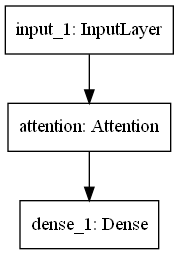

In [4]:
tf.keras.utils.plot_model(model, to_file='attention-network.png')

### AFM注意力機制
- 兩兩特徵域注意力

In [5]:
tf.matmul(np.random.rand(3, 2), np.random.rand(10, 2), transpose_b=True)

<tf.Tensor: shape=(3, 10), dtype=float64, numpy=
array([[1.05899948, 1.05095217, 0.99624332, 0.59168742, 0.70293557,
        0.66682034, 0.88348986, 0.77728853, 0.39574051, 0.15802991],
       [1.00200586, 0.98686569, 0.83753616, 0.6240536 , 0.60798865,
        0.63598126, 0.67242472, 0.62852547, 0.33587043, 0.23567573],
       [1.05743909, 1.05018737, 1.00571926, 0.58412897, 0.70784772,
        0.66531211, 0.89921627, 0.78727867, 0.39917418, 0.14882557]])>

In [58]:
import tensorflow as tf

class AFMAttentionNet(tf.keras.layers.Layer):
    def __init__(self, attn_units):
        super(AFMAttentionNet, self).__init__()
        # 假设我们使用一个全连接层作为注意力网络的核心
        self.attn_dense1 = tf.keras.layers.Dense(attn_units, activation='relu')
        self.attn_dense2 = tf.keras.layers.Dense(1, activation=None)  # 输出注意力分数
        self.softmax = tf.keras.layers.Softmax(axis=1)

    def call(self, embeddings):
        # embeddings 应该是一个列表，其中每个元素都是一个特征的嵌入向量
        interactions = []
        for i in range(len(embeddings)):
            for j in range(i+1, len(embeddings)):
                # 计算特征向量的交互（element-wise product）
                interaction = tf.multiply(embeddings[i], embeddings[j])
                interactions.append(interaction)

        # 将所有交互向量堆叠成一个矩阵
        interactions = tf.stack(interactions, axis=1)  # [batch_size, num_interactions, embedding_dim]

        # 计算注意力分数
        attn_scores = self.attn_dense1(interactions)
        attn_scores = self.attn_dense2(attn_scores)
        attn_scores = tf.squeeze(attn_scores, -1)  # [batch_size, num_interactions]
        attn_weights = self.softmax(attn_scores)

        # 加权求和得到最终的交互表示
        weighted_interactions = interactions * tf.expand_dims(attn_weights, axis=-1)
        output = tf.reduce_sum(weighted_interactions, axis=1)  # [batch_size, embedding_dim]

        return output


In [59]:
# 建立一個 functional AFM 模型
def create_AFM_model(num_features, embedding_dim, attn_units):
    # 輸入層：每個特征都是一個整數索引
    inputs = [tf.keras.Input(shape=(1,), dtype=tf.int32) for _ in range(num_features)]
    
    # 嵌入層：將每個特征索引轉化為嵌入向量
    embeddings = [tf.keras.layers.Embedding(1000, embedding_dim)(inp) for inp in inputs]  # 假定每个特征有1000个可能的值
    embeddings = [tf.squeeze(embed, axis=1) for embed in embeddings]  # 去除不必要的维度
    
    # 注意力和交互層
    interactions = AFMAttentionNet(attn_units)(embeddings)
    
    # 輸出層：此例為回歸任務
    output = tf.keras.layers.Dense(1)(interactions)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# 使用上述函数創建模型
model = create_AFM_model(num_features=5, embedding_dim=8, attn_units=10)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

### 實現一個作用於向量的注意力機制，透過簡單的全連接

In [82]:
class SimpleAttentionNet(tf.keras.layers.Layer):
    def __init__(self):
        super(SimpleAttentionNet, self).__init__()
        self.softmax_layer = tf.keras.layers.Softmax()
        self.multiply = tf.keras.layers.Multiply()
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer='random_normal',
            trainable=True
        )
    
    def call(self, embeddings):
        # embeddings: (batch_size, seq, embed_dim)
        attn_scores = tf.matmul(embeddings, self.w)  # (batch_size, seq, 1)
        attn_scores = tf.squeeze(attn_scores, axis=-1) # (batch_size, seq)
        attn_probs = self.softmax_layer(attn_scores)   # (batch_size, seq) (0~1)
        
        # 為了相乘需要到同樣的形狀
        attn_probs = tf.expand_dims(attn_probs, axis=-1) # (batch_size, seq, 1)  # 之後會廣播
        print(attn_probs, tf.reduce_sum(attn_probs))#, attn_probs.numpy.sum())
        weighted_embeddings = embeddings * attn_probs    # (batch_size, seq, embed_dim)
        
        output =  tf.reduce_sum(weighted_embeddings, axis=1) # (batch_size, embed_dim)
        return output

In [83]:
## 確認是否如同所想

inputs = tf.keras.Input(shape=(10,))
embeddings = tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=10)(inputs)
attn_weighted_embeddings = SimpleAttentionNet()(embeddings)

model = keras.Model(inputs, attn_weighted_embeddings)
model.summary()

Tensor("simple_attention_net_6/ExpandDims:0", shape=(None, 10, 1), dtype=float32) Tensor("simple_attention_net_6/Sum:0", shape=(), dtype=float32)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 10, 32)            320000    
_________________________________________________________________
simple_attention_net_6 (Simp (None, 32)                32        
Total params: 320,032
Trainable params: 320,032
Non-trainable params: 0
_________________________________________________________________


In [84]:
## 測試輸出

test_inputs = np.array([i for i in range(1, 1+10)])

model(test_inputs)

tf.Tensor(
[[0.09892201]
 [0.10125554]
 [0.10042584]
 [0.0988341 ]
 [0.10029733]
 [0.10064111]
 [0.09915125]
 [0.09973518]
 [0.1004338 ]
 [0.10030389]], shape=(10, 1), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.00633986, -0.00643159,  0.00284408, -0.0027058 ,  0.00566349,
       -0.00116355,  0.0145762 , -0.02578114,  0.00711107, -0.02054787],
      dtype=float32)>